<a href="https://colab.research.google.com/github/jijan67/Multi-Weather-Classification-System-Using-VGG19-and-XGBoost/blob/main/Multi_Weather_Classification_System_Using_VGG19_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load data
data_dir = '/content/drive/MyDrive/MultiWeatherDataset'

In [ ]:
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    pics = os.listdir(foldpath)
    for pic in pics:
        pic_path = os.path.join(foldpath, pic)
        filepaths.append(pic_path)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='Pic Path')
LSeries = pd.Series(labels, name='Labels')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Labels'])


In [ ]:
# Initialize VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Function to extract features using VGG19
def extract_features_vgg(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = vgg_model.predict(img_array)
    return features.flatten()


In [ ]:
# Extract features for train and test sets
X_train = np.array([extract_features_vgg(img_path) for img_path in train_df['Pic Path']])
X_test = np.array([extract_features_vgg(img_path) for img_path in test_df['Pic Path']])
y_train = train_df['Labels']
y_test = test_df['Labels']


1/1 [==============================] - 0s 18ms/step


In [ ]:
# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_encoded)), random_state=42)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [ ]:
# Predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [ ]:
# Decode predictions (if needed)
y_pred_train_decoded = label_encoder.inverse_transform(y_pred_train)
y_pred_test_decoded = label_encoder.inverse_transform(y_pred_test)

In [ ]:
# Calculate model accuracy
test_accuracy = accuracy_score(y_test, y_pred_test_decoded)
train_accuracy = accuracy_score(y_train, y_pred_train_decoded)
print(f"Model Test Accuracy: {test_accuracy}")
print(f"Model Train Accuracy: {train_accuracy}")

Model Test Accuracy: 0.8925831202046036
Model Train Accuracy: 0.9993593850096092


In [ ]:
# Evaluate the model
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train_decoded))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test_decoded))

Training Classification Report:
              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00       240
         Fog       1.00      1.00      1.00       240
        Rain       1.00      1.00      1.00       172
        Sand       1.00      1.00      1.00       258
       Shine       1.00      1.00      1.00       202
        Snow       1.00      1.00      1.00       163
     Sunrise       1.00      1.00      1.00       286

    accuracy                           1.00      1561
   macro avg       1.00      1.00      1.00      1561
weighted avg       1.00      1.00      1.00      1561

Test Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.90      0.93        60
         Fog       0.82      0.78      0.80        60
        Rain       0.93      0.93      0.93        43
        Sand       0.86      0.83      0.84        65
       Shine       0.90      0.92      0.91        51
        Snow      

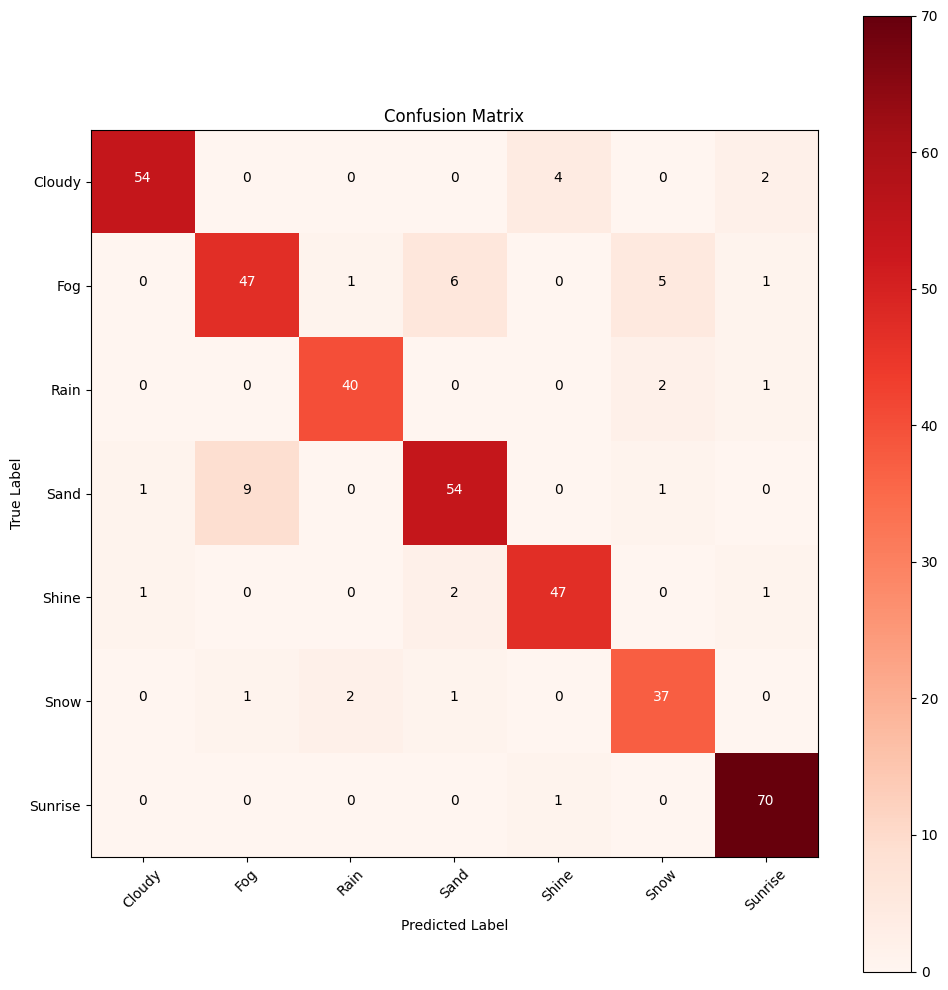

In [ ]:
# Confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the unique classes
classes = np.unique(np.concatenate((y_test, y_pred_test_decoded), axis=0))

# Compute confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test_decoded)

# Plot confusion matrix
plot_confusion_matrix(cm_test, classes)

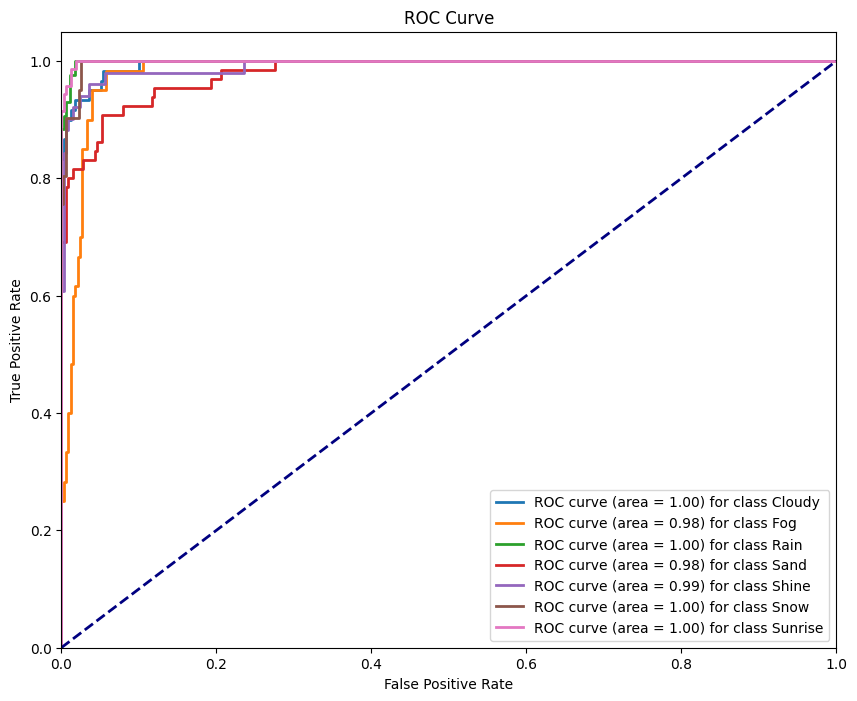

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve and AUC score for each class
def plot_roc_curve(y_true, y_pred_proba, classes):
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Convert labels to one-hot encoding
y_test_one_hot = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))

# Combine predictions into probability scores
y_pred_proba_test = xgb_model.predict_proba(X_test)

# Plot ROC curve for each class
plot_roc_curve(y_test_one_hot, y_pred_proba_test, label_encoder.classes_)
